<h1><center>STAT-542 HW4</center></h1>
Sharvi Tomar (stomar2)

## Question 1 [35 Points] Regression and Optimization with Huber Loss

When fitting linear regressions, outliers could significantly affect the fitting results. However, manually checking and removing outliers can be tricky and time consuming. Some regression methods address this problem by using a more robust loss function. For example, one such regression is to minimize the objective function


$$
\frac{1}{n} \sum_{i=1}^n \ell_\delta(y_i - x_i^\text{T} \boldsymbol \beta),
$$

where the loss function $\ell_{\delta}$ is the __Huber Loss__, defined as
$$
\ell_\delta( a ) =   \begin{cases}
    \frac{1}{2} a^2       & \quad \text{if } |a| \leq \delta \\
    \delta(|a| - \frac{1}{2} \delta)  & \quad \text{o.w.}
  \end{cases}
$$

Here is a visualization that compares Huber loss with the $\ell_2$ loss. We can see that the Huber loss assigns much less value when $y_i - x_i^\text{T} \boldsymbol \beta$ is more extreme (outliers). 

In [2]:
# define the Huber loss function
def Huber(a, delta = 1):
    if abs(a) <= delta:
        return 0.5*(a**2)
    else:
        return delta*(abs(a) - 0.5*delta)

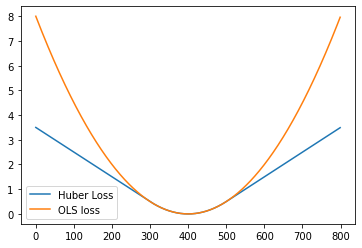

In [10]:
# plot against L2
import numpy as np
x = np.arange (-4, 4, 0.01)

huber_x = [Huber(el) for el in x]

# Plotting 
from matplotlib import pyplot as plt
plt.plot(huber_x)
plt.plot(0.5*(x**2))
plt.legend(["Huber Loss", "OLS loss"])
plt.show()

In [26]:
# generate data from a simple linear model 
import random    
random.seed(542)  

n = 150
x = np.random.uniform(0,1,n)
X = np.stack((np.ones(n), x))
y = np.matmul(np.transpose(X), [0.5, 1]) + np.random.normal(0, 1, n)
  
# create an outlier
y[np.argmin(X[1])] = -30

a) [5 pts] Fit an OLS model with the regular $\ell_2$ loss. Report your coefficients (do not report other information). Although this is only one set of samples, but do you expect this estimator to be biased based on how we set up the observed data? Do you expect the parameter $\beta_1$ to bias upwards or downwards? Explain your reason. Hint: is the outlier pulling the regression line slope up or down?

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(np.transpose(X), y)

print("The model coefficients are: ", model.coef_)

The model coefficients are:  [0.         2.42805681]


1. do you expect this estimator to be biased based on how we set up the observed data? 
2. Do you expect the parameter $\beta_1$ to bias upwards or downwards? Explain your reason. Hint: is the outlier pulling the regression line slope up or down?

b) [10 pts] Define your own Huber loss function `huberLoss(b, trainX, trainY)` given a set of observed data with tuning parameter $\delta = 1$. Here, `b` is a $p$-dim parameter vector, `trainX` is a $n \times p$ design matrix and $trainY$ is the outcome. This function should return a scalar as the empirical loss. You can use our `Huber` function in your own code. After defining this loss function, use the `optim()` function to solve the parameter estimates. Finally, report your coefficients.  
    - Use `b = (0, 0)` as the initial value.
    - Use `BFGS` as the optimization method.

In [ ]:
delta = 1

def huberLoss(b, trainX, trainY):

c) [20 pts] We still do not know which method performs better in this case. Let's use a simulation study to compare the two methods. Complete the following

    * Set up a simulation for 1000 times. At each time, randomly generate a set of observed data, but also force the outlier with our code `y[which.min(X[, 2])] = -30`.
    * Fit the regression model with $\ell_2$ loss and Huber loss, and record the slope variable estimates.
    * Make a side-by-side boxplot to show how these two methods differ in terms of the estimations. Which method seem to have more bias? and report the amount of bias based on your simulation. What can you conclude from the results? Does this match your expectation in part a)? Can you explain this (both OLS and Huber) with the form of loss function, in terms of what their effects are?

In [ ]:
nsim = 1000

## Question 2 [65 Points] Scaling and Coordinate Descent for Linear Regression

**Scaling issue** In the practice, we usually standardize each covariate/feature to mean 0 and standard deviation 1. Standardization is essential when we apply $\ell_2$ and $\ell_1$ penalty on the loss function, because if the covariates are with different scales, then they are penalized differently. Without prior information, we should prevent that from happening. Besides, scaling the data also help to make the optimization more stable, since the step size in many descent algorithms could be affected by the scale.

In practice, after obtaining the coefficients fitted with scaled data, we want to recover the original coefficients of the unscaled data. For this question, we use the following intuition:

\begin{align}
\frac{Y - \bar{Y}}{\text{sd}_y} =&~ \sum_{j=1}^p \frac{X_j - \bar{X}_j}{\text{sd}_j} \gamma_j \\
Y =&~ \underbrace{\bar{Y} - \sum_{j=1}^p \bar{X}_j \frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_0} + \sum_{j=1}^p X_j \underbrace{\frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_j},
\end{align}

  * In this equation, the first line is the model fitted with scaled and centered data. And we obtain the fitted parameters as $\gamma_j$'s
  * In the second line, the coefficients $\beta_j$'s for the original data is recovered.
  * When fitting the scaled and centered data, no intercept term is needed. 

Based on this relationship, we perform the following when fitting a linear regression:

  * Center and scale both $\mathbf{X}$ (column-wise) and $\mathbf{y}$ and denote the processed data as $\frac{Y - \bar{Y}}{\text{sd}_y}$ and $\frac{X_j - \bar{X}_j}{\text{sd}_j}$ in the above formula. Make sure that the standard error of each variable is 1 after scaling. This means that you should use $N$, not $N-1$ when calculating the estimation of variance. 
  * Fit a linear regression using the processed data based on the no-intercept model, and obtain the parameter estimates $\gamma_j$'s.
  * Recover the original parameters $\beta_0$ and $\beta_j$'s.

Use the following code to generate your data:

In [38]:
random.seed(10)
n = 20
p = 3

# covariance matrix
V = np.array([[0.3, 0.3, 0.3]] * 3)
np.fill_diagonal(V, [1, 1, 1])
  
# generate data
X_org = np.random.multivariate_normal([0, 0, 0], V, (3, 20))
true_b = [1, 2, 0]
y_org = np.matmul(X_org, true_b) + np.random.normal(0, 1, n)

a) [10 pts] Fit an OLS estimator with the original data `Y_org` and `X_org` by `lm()`. Also, fit another OLS with scaled data by `lm()`. Report the coefficients/parameters. Then, transform coefficients from the second approach back to its original scale, and match with the first approach. Summarize your results in a single table: The rows should contain three methods: OLS, OLS Scaled, and OLS Recovered, and there should be four columns that represents the coefficients for each method. You can consider using the `kable` function, but it is not required. 

b) Instead of using the $lm()$ function, write your own coordinate descent code to solve the scaled problem. This function will be modified and used next week when we code the Lasso method. Complete the following steps:

    - [10 pts] i) Given the loss function $L(\beta) =  \| y - X\beta\|^2$ or  $\sum_{i=1}^n (y_i - \sum_{j=0}^p x_{ij} \beta_j)^2$ , derive the updating/calculation formula of coefficient $\beta_j$, when holding all other covariates fixed. You must use LaTex to typeset your derivation with proper explaination of notations. Write down the formula (in terms of $y$, $x$ and $\beta$'s) of residual $r$ before and after this update. Based on our lecture, how to make the update of $r$ computationally efficient? 
    
    - [30 pts] ii) Implement this coordinate descent method with your own code to solve OLS with the scaled data. Print and report your **scaled coefficients** (no need to recover the original version) and compare with the result from the previous question.
      - Do not use functions from any additional library.
      - Start with a vec $\boldsymbol \beta = 0$.
      - Run your coordinate descent algorithm for a maximum of maxitr = 100 iterations (while each iteration will loop through all variables). However, stop your algorithm if the $\beta$ value of the current iteration is sufficiently similar to the previous one, i.e., $\|\beta^{(k)}− \beta ^{(k−1)}\|_1 \leq$ tol. Set $tol = 1e-7$ where $\| \cdot \|_1$ is the L1 distance.
      
    -  [5 pts] Make a plot to analyze the convergence of the coordinate descent. On the x-axis, we use the number of iteration. On the y-axis, use $\log(\text{Loss}_k - \text{trueLoss})$. Here, \text{trueLoss} is the emperical loss based on the true optimizor, which we can simply use the solution from the $lm()$ function (the scaled version). The $\text{loss}_k$ is the loss function at the begining of the $k$-th iteration (Keep in mind that within each iteration, we will loop over all $\beta_j$). If this plot displays a stragiht line, then we say that this algorithm has a linear convergence rate. Of course, this is at the log scale. 
